In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy import coordinates
from astropy import constants as co
from astropy import units as u
from maria import reader

In [5]:
import socket

'tigressdata2.princeton.edu'

In [9]:
hostname = socket.gethostname()
if hostname == 'tigressdata2.princeton.edu':
    prefix = '/tiger/scratch/'
elif hostname == 'tiger2-sumire.princeton.edu':
    prefix = '/scratch/'
tract_catalog_path = f"{prefix}gpfs/sd8758/merian/catalog/S20A/$TRACTNUM/meriandr1_use_$TRACTNUM_S20A.fits"
summary_catalog_path = f"{prefix}gpfs/sd8758/merian/catalog/S20A/meriandr1_master_catalog.fits"

In [84]:
%%time
summary = reader.read_summary_catalog()

CPU times: user 15.5 s, sys: 19 s, total: 34.5 s
Wall time: 34.7 s


In [79]:
%%time
_ = reader.read_summary_catalog (return_dataframe=False)

CPU times: user 5.01 s, sys: 2.71 s, total: 7.72 s
Wall time: 7.82 s


In [97]:
cat = reader.read_tract_catalog(9333, usecode='rmagcut')

In [48]:
columns = [
    #'coord_ra_Merian', 
    #'coord_dec_Merian',
    #'N708_cModelFlux_Merian',
    #'N708_cModelFluxErr_Merian',
    'r_cModelFlux_Merian',
    'r_cModelFluxErr_Merian',
    'r_gaap1p0Flux_Merian', 
    'r_gaap1p0FluxErr_Merian', 
    'N708_gaap1p0Flux_Merian', 
    'N708_gaap1p0FluxErr_Merian',
    'i_gaap1p0Flux_Merian', 
    'i_gaap1p0FluxErr_Merian'    
]

In [56]:
catalog = reader.assemble_catalog ( columns, usecode='rmagcut', verbose=True, usescratch=False )

Concatenating 355 tracts
Processed 50/355 tracts after 24.10 sec
Processed 100/355 tracts after 46.91 sec
Processed 150/355 tracts after 82.77 sec
Processed 200/355 tracts after 122.93 sec
Processed 250/355 tracts after 156.39 sec
Processed 300/355 tracts after 195.85 sec
Processed 350/355 tracts after 231.71 sec


In [134]:
# catalog = reader.read_tract_catalog(9333, usecode='rmagcut')
medcontinuum = 0.5*(catalog['r_gaap1p0Flux_Merian'] + catalog['i_gaap1p0Flux_Merian'])

n708_continuum =  0.5*(catalog['r_gaap1p0Flux_Merian'] + catalog['i_gaap1p0Flux_Merian'])
n540_continuum =  0.5*(catalog['g_gaap1p0Flux_Merian'] + catalog['r_gaap1p0Flux_Merian'])

n708_color = -2.5*np.log10(catalog['N708_gaap1p0Flux_Merian']/n708_continuum)
n540_color = -2.5*np.log10(catalog['N540_gaap1p0Flux_Merian']/n540_continuum)

rmag = -2.5*np.log10(catalog['r_cModelFlux_Merian'].astype(float)) + 31.
selection = (n708_color<-0.2)&(n540_color<-0.1)&(rmag<20)

Text(0.95, 0.95, 'selected')

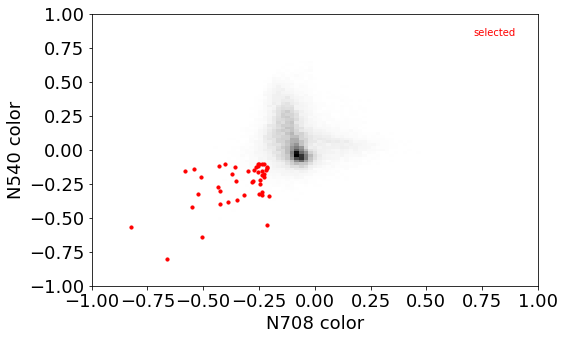

In [158]:

with plt.rc_context({'font.size':18}):
    plt.figure(figsize=(8,5))
    ax = plt.subplot(111)
_=plt.hist2d (
    n708_color,
    n540_color,
    bins=[np.linspace(-1,1.,100),np.linspace(-1,1,100)],
    cmap='Greys'
)
plt.scatter (
    n708_color[selection],
    n540_color[selection],    
    s=10,
    color='r'
)
plt.xlabel('N708 color')
plt.ylabel('N540 color')
plt.text ( 0.95, 0.95, 'selected', color='r', transform=ax.transAxes, ha='right', va='top' )
#plt.axhline(0.)
#plt.yscale('log')

In [144]:
np.nanquantile(n708_color,[0.1,.5])

array([-0.21047855, -0.09174084])

In [145]:
np.nanquantile(n540_color,[0.1,.5])

array([-0.11387239,  0.05010995])

In [152]:
summary.reindex(catalog[(n708_color<-0.2)&(n540_color<-0.1)&(rmag<20)]['objectId_Merian'])[['coord_ra_Merian','coord_dec_Merian']].to_csv('/tiger/scratch/gpfs/kadofong/merian_scratch/viewer.csv', index=True, index_label='Name', header=['RA','Dec'])

In [147]:
alfalfa = ascii.read( '/scratch/gpfs/kadofong/merian_scratch/external_catalogs/alfalfa/table2.dat',
                      readme='/scratch/gpfs/kadofong/merian_scratch/external_catalogs/alfalfa/ReadMe')
alfalfa.add_index('AGC')              

In [150]:
alfalfa['z'] = alfalfa['Vhel'] / co.c.to(u.km/u.s).value

In [211]:
len(optical_strings)

31502

In [230]:
len(alfalfa[~alfalfa['RAOh'].mask])

31158

In [272]:

hi_strings = [ f"{x['RAh']}:{x['RAm']}:{x['RAs']} {x['DE-']}{x['DEd']}:{x['DEm']}:{x['DEs']}" for x in alfalfa ]
optical_strings = [ f"{x['RAOh']}:{x['RAOm']}:{x['RAOs']} {x['DEO-']}{x['DEOd']}:{x['DEOm']}:{min(59.9,x['DEOs'])}" for x in alfalfa[~alfalfa['RAOh'].mask] ]
#coord_strings = []


In [346]:
acoords = coordinates.SkyCoord ( hi_strings, unit=(u.hourangle, u.deg))

In [319]:
snr = catalog['N708_gaap1p0Flux_Merian']/catalog['N708_gaap1p0FluxErr_Merian']

In [332]:
stripped = catalog.loc[(fluxexcess > np.nanquantile(fluxexcess, 0.95))&(snr>10.)&(catalog['coord_dec_Merian']>-1.)&(catalog['N708_gaap1p0Flux_Merian']>np.nanquantile(catalog['N708_gaap1p0Flux_Merian'].astype(float), .95))]

In [333]:
stripped.shape

(1443482, 8)

In [334]:
stripped

,coord_ra_Merian,coord_dec_Merian,r_gaap1p0Flux_Merian,r_gaap1p0FluxErr_Merian,N708_gaap1p0Flux_Merian,N708_gaap1p0FluxErr_Merian,i_gaap1p0Flux_Merian,i_gaap1p0FluxErr_Merian
3324923162394642683,159.232782,-0.982432,8236.455066,53.619175,13630.538418,74.791325,16614.426481,40.797757
3324923162394643600,159.172133,-0.984207,34453.933006,81.315302,41636.545205,105.533925,42330.903574,71.079635
3324923162394643939,159.256692,-0.978171,7728.183263,55.801394,12451.751432,75.650592,13078.214477,65.4275
3324923162394644031,159.187711,-0.978656,9271.387087,44.012499,13559.159918,73.848369,14897.481226,46.995117
3324923162394644404,159.172848,-0.974977,81365.731894,93.294553,105489.882039,144.488651,111957.75373,95.592872
...,...,...,...,...,...,...,...,...
3339295978392931189,218.429786,-0.375654,11602.970762,41.188794,17035.997831,130.165338,20721.146154,40.100388
3339295978392931228,218.429241,-0.364826,33614.34863,64.792041,39860.012979,205.893475,39750.76624,74.059725
3339295978392931463,218.429393,-0.318645,7285.225666,40.454298,9725.042548,125.309592,10091.369271,35.992468
3339295978392931469,218.430309,-0.314908,18247.568189,44.061312,27333.77524,134.251315,30206.886088,45.040292


In [347]:
mcoords = coordinates.SkyCoord ( stripped['coord_ra_Merian'], stripped['coord_dec_Merian'], unit=u.deg )

KeyboardInterrupt: 

In [348]:
idx, d2d, _ = acoords.match_to_catalog_sky ( mcoords )

In [349]:
in_merian_field = d2d < (10.*u.arcmin)

In [354]:
in_merian_range = (alfalfa['z']>0.05)

In [355]:
(in_merian_field&in_merian_range).sum()

56

In [356]:
#matchids = idx[in_merian_field&in_merian_range]
for idx,row in enumerate(acoords[in_merian_field&in_merian_range]):
    print ( f"{row.ra.value} {row.dec.value}")

130.13624999999996 2.176111111111111
130.9395833333333 4.583333333333333
131.88666666666663 0.5505555555555556
132.00541666666666 4.258055555555556
132.26916666666665 4.3277777777777775
133.45416666666662 0.22722222222222224
133.56375 2.2330555555555556
133.685 1.107777777777778
134.39999999999998 2.25
135.23125 2.1941666666666664
135.3825 2.163611111111111
135.5370833333333 3.8672222222222223
135.78541666666666 4.685555555555556
135.97916666666666 4.579166666666667
136.02499999999998 2.794722222222222
136.05499999999998 3.875
136.09624999999997 4.019166666666667
136.84583333333333 4.0777777777777775
137.45874999999998 0.42000000000000004
138.54416666666665 0.8325
138.72291666666663 4.641111111111111
138.74041666666665 4.684722222222223
138.80083333333332 1.5005555555555556
138.97458333333333 3.37
139.33916666666667 0.31916666666666665
140.5425 3.9675000000000002
140.67291666666665 2.107222222222222
140.87041666666664 4.005277777777778
140.95041666666665 1.7513888888888889
141.42958333

In [360]:
from matplotlib import patches

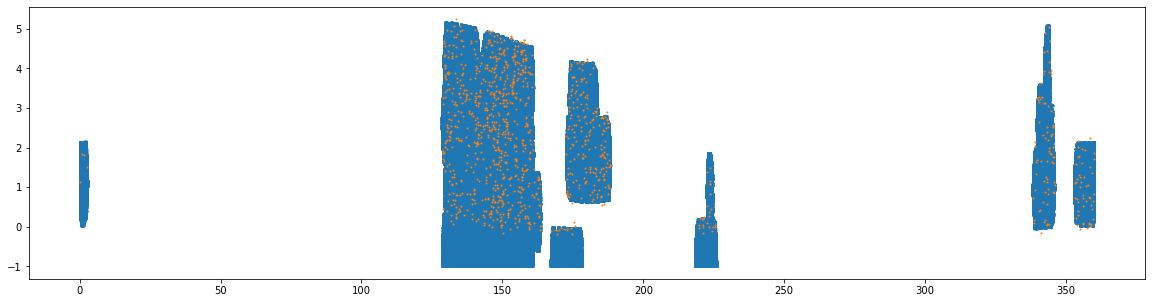

In [362]:
plt.figure(figsize=(20,5))
ax = plt.subplot(111)

plt.scatter ( stripped['coord_ra_Merian'], stripped['coord_dec_Merian'], s=1 )
plt.scatter ( acoords[in_merian_field].ra, acoords[in_merian_field].dec,s=1 )



In [359]:
(12*u.hourangle + 28. * u.arcmin).to(u.deg)

<Quantity 180.46666667 deg>